# PACE

Este tutorial demuestra el acceso a los datos de color del océano de PACE. Se puede encontrar información general sobre el conjunto de datos en el sitio web de PACE (ver [aquí](https://oceandata.sci.gsfc.nasa.gov)).

**Requisitos para este tutorial**
1. Contar con una cuenta de Earth Data Login.
2. Tener un EDL Token valido.

Tambien se puede utilizar el metodo de Nombre de Usuario / Contrasena descrito en el tutorial de [Autenticacion](Authentication)

**Objectivos**
 
Utilizar [pydap](https://pydap.github.io/pydap/) para

- Acceder a [EarthData in the cloud](https://www.earthdata.nasa.gov/) de la NASA mediante el uso de `tokens`.
- Acceder/descargar datos cientificos del programa de `PACE` utilizando los servidores de `OPeNDAP`.

`Autor`: Miguel Jimenez-Urias, '24

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from pydap.net import create_session
from pydap.client import open_url
import cartopy.crs as ccrs
import xarray as xr

### Accesso a EARTHDATA

El catalogo de PACE mediante el servidor de OPeNDAP se puede accesar [aqui](https://oceandata.sci.gsfc.nasa.gov/opendap/PACE_OCI/L3SMI/2024/contents.html). Los datos empezaron a publicarse en 2024.


In [2]:
# slow download URL / higher resolution
url_DAP4 = "http://oceandata.sci.gsfc.nasa.gov/opendap/PACE_OCI/L3SMI/2024/0310/PACE_OCI.20240310.L3m.DAY.CHL.V2_0.chlor_a.4km.NRT.nc"

### Autenticacion via `.netrc`

Las credenciales son recuperadas automaticamente por `pydap`.


In [3]:


session_extra = {"token": "YourToken"}

my_session = create_session(session_kwargs=session_extra)

In [4]:
%%time
ds_full = open_url(url_DAP4, session=my_session, protocol='dap4')

CPU times: user 26.1 ms, sys: 4.46 ms, total: 30.5 ms
Wall time: 574 ms


In [5]:
ds_full.tree()

.PACE_OCI.20240310.L3m.DAY.CHL.V2_0.chlor_a.4km.NRT.nc
├──lat
├──lon
├──chlor_a
└──palette


```{note}
PyDAP accesa a los metadatos solamente. Los valores/arreglos numericos no se an descargado and no data has been downloaded yet!
```

In [6]:
ds_full['chlor_a'].attributes

{'long_name': 'Chlorophyll Concentration, OCI Algorithm',
 'units': 'mg m^-3',
 'standard_name': 'mass_concentration_of_chlorophyll_in_sea_water',
 '_FillValue': -32767.0,
 'valid_min': 0.00100000005,
 'valid_max': 100.0,
 'reference': 'Hu, C., Lee Z., and Franz, B.A. (2012). Chlorophyll-a algorithms for oligotrophic oceans: A novel approach based on three-band reflectance difference, J. Geophys. Res., 117, C01011, doi:10.1029/2011JC007395.',
 'display_scale': 'log',
 'display_min': 0.00999999978,
 'display_max': 20.0,
 'dims': ['lat', 'lon'],
 'Maps': ('/lat', '/lon')}

In [7]:
print('uncompressed dataset size [GBs]: ', ds_full.nbytes / 1e9)

uncompressed dataset size [GBs]:  0.149351808


In [8]:
ds_full['chlor_a'].shape

(4320, 8640)

In [9]:
print('uncompressed dataset size [GBs]: ', ds_full['chlor_a'].nbytes / 1e9)

uncompressed dataset size [GBs]:  0.1492992


### El arreglo numerico se descarga al indexar la variable pydap


En este paso, descargamos y decodificamos todos los valores de `longitude` y `latitude`. Cada una de estas variables es un arreglo uni-dimensional, minimizando la cantidad que deseamos descargar.

**Decodificando los valores del arreglo numerico:**
Un paso muy importante es la decodification de los valores numericos del archivo. `pydap` no decodifica los valores numericos lo que significa que el usuario debe de hacerlo manualmente. Para hacerlo, el usuario tiene que estar un poco familiarizado con las convenciones de metadatos


**CF - Conventions**
Cada archivo cientifico accessible mediante servidores de OPeNDAP cuenta con metadatos que describen el contenido del archivo de manera global, y tambien describen los valores de cada variable. A estos metadatos de les llama atributos y los mas comunes (a nivel de variable) son:

- `standard name`
- `units`
- `_FillValue`
- `scale_factor`
- `off_set`

A continuacion demostramos una pequena function que utiliza los attributos de cada variable para decodificarla




In [10]:
def decode(variable) -> np.ndarray:
    """Decodes the variable BaseType according with atributes:
        _FillValue
        scale_factor

    Parameters:
        variable: BaseType (pydap model)
    """
    scale_factor = 1
    _Fillvalue = None

    if 'scale_factor' in variable.attributes:
        scale_factor = variable.scale_factor
    if '_FillValue' in variable.attributes:
        data = np.where(variable.data == variable._FillValue, np.nan, variable.data)    
    else:
        data = variable.data
    return scale_factor * data

### Ahora si, descargamos variables uni-dimensionales que definen la cobertura espacial del archivo

In [11]:
lon = decode(ds_full['lon'][:])
lat = decode(ds_full['lat'][:])

In [12]:
print("tamano del arreglo de latitud: ", lat.shape)

tamano del arreglo de latitud:  (4320,)


In [13]:
print("Rango de valores del arreglo de latitud: ", (lat.min(), lat.max()))

Rango de valores del arreglo de latitud:  (np.float32(-89.97917), np.float32(89.979164))


In [14]:
print("tamano del arreglo de longitud: ", lon.shape)

tamano del arreglo de longitud:  (8640,)


In [15]:
print("Rango de valores del arreglo de longitud: ", (lon.min(), lon.max()))

Rango de valores del arreglo de longitud:  (np.float32(-179.97917), np.float32(179.97917))


```{warning}
No todas las variables que definen los valores de los arreglos de latitud y longitud son monotonos. En este caso, el achivo describe informacion en el nivel de procesamiento L3 (`level 3` por sus siglas en ingles). En este caso, la mayoria de las variables estan mapeadas a una malla uniforma de longitude y latitude. Aun asi, se recomienda explorar detalladamente si las coordenadas de longitude y latitude estan definidas en una malla uniforme. 
```

### Definimos ahora la zona de interes

Para reducir el tamano de la descarga del archivo remoto en el servidor de OPeNDAP, buscaremos los indices que definen una zona de interes. Ya teniendo los valores, podremos descargar las variables multidimensionales de interest.



In [16]:
minLon = -96 # longitud minima de interes
maxLon = 10 # longitud maxima de interes

In [17]:
minLat = 6 # longitude minima de interes
maxLat = 70 # longitud maxima de interes

In [18]:
iLon = np.where((lon>minLon)&(lon < maxLon))[0]
iLat= np.where((lat>minLat)&(lat < maxLat))[0]

## Visualizacion
Como buena practica, es recomendable revisar que los valores encontrados corresponden a los de interes.

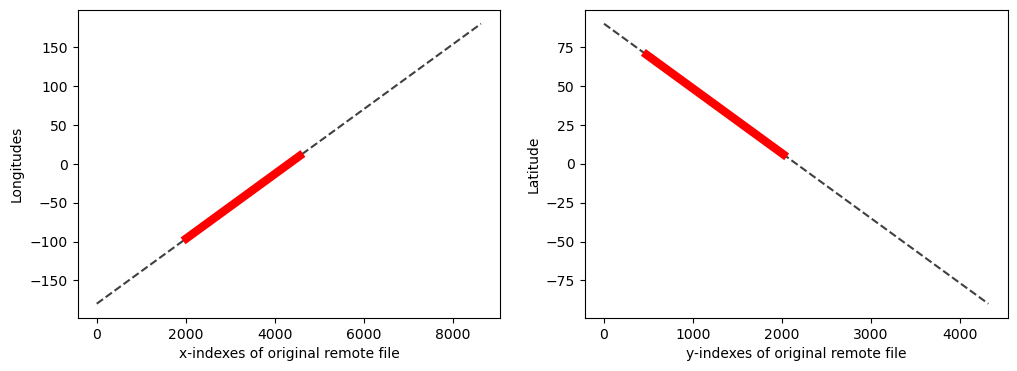

In [19]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(lon, 'k--', alpha=0.75)
plt.plot(iLon,lon[iLon], 'r', lw=6)
plt.xlabel('x-indexes of original remote file')
plt.ylabel("Longitudes")
plt.subplot(122)
plt.plot(lat,'k--', alpha=0.75)
plt.plot(iLat,lat[iLat], 'r', lw=6)
plt.xlabel('y-indexes of original remote file')
plt.ylabel("Latitude")
plt.show()

## Descargamos la variable de interes


In [20]:
%%time
CHLOR_A = decode(ds_full['chlor_a'][iLat[0]:iLat[-1],iLon[0]:iLon[-1]])

CPU times: user 129 ms, sys: 51.7 ms, total: 181 ms
Wall time: 1.04 s


In [21]:
## Solo la region de interes fue descargada

In [22]:
print("tamano original de archivo remoto: ", ds_full['chlor_a'].shape)

tamano original de archivo remoto:  (4320, 8640)


In [23]:
print("tamano del archivo que se descargo: ",CHLOR_A.shape)

tamano del archivo que se descargo:  (1535, 2543)


In [24]:
Lon, Lat = np.meshgrid(lon[iLon[0]:iLon[-1]], lat[iLat[0]:iLat[-1]])

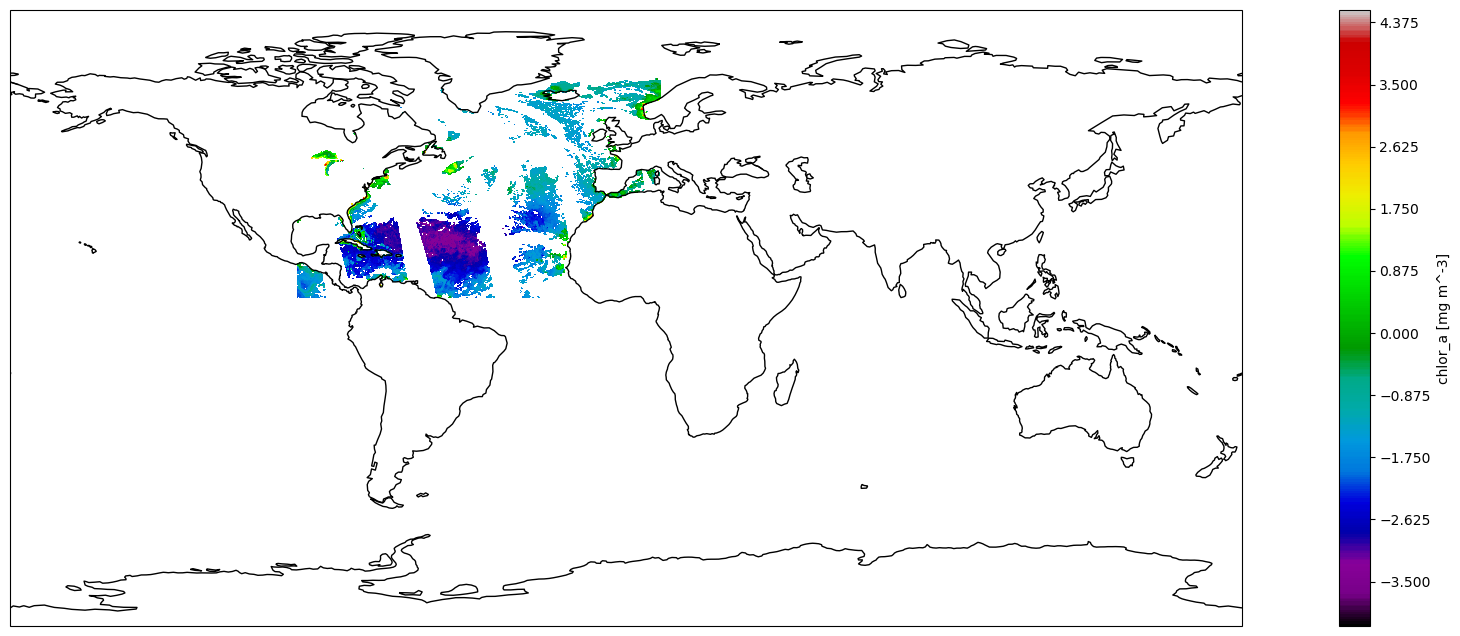

In [25]:
plt.figure(figsize=(25, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
ax.coastlines()
plt.contourf(Lon, Lat, np.log(CHLOR_A), 400, cmap='nipy_spectral')
plt.colorbar().set_label(ds_full['chlor_a'].name + ' ['+ds_full['chlor_a'].units+']');

**Fig 2.** Visualizacion de la variable `Chlorophyll a` que se descargo de un servidor de OPeNDAP remoto. 

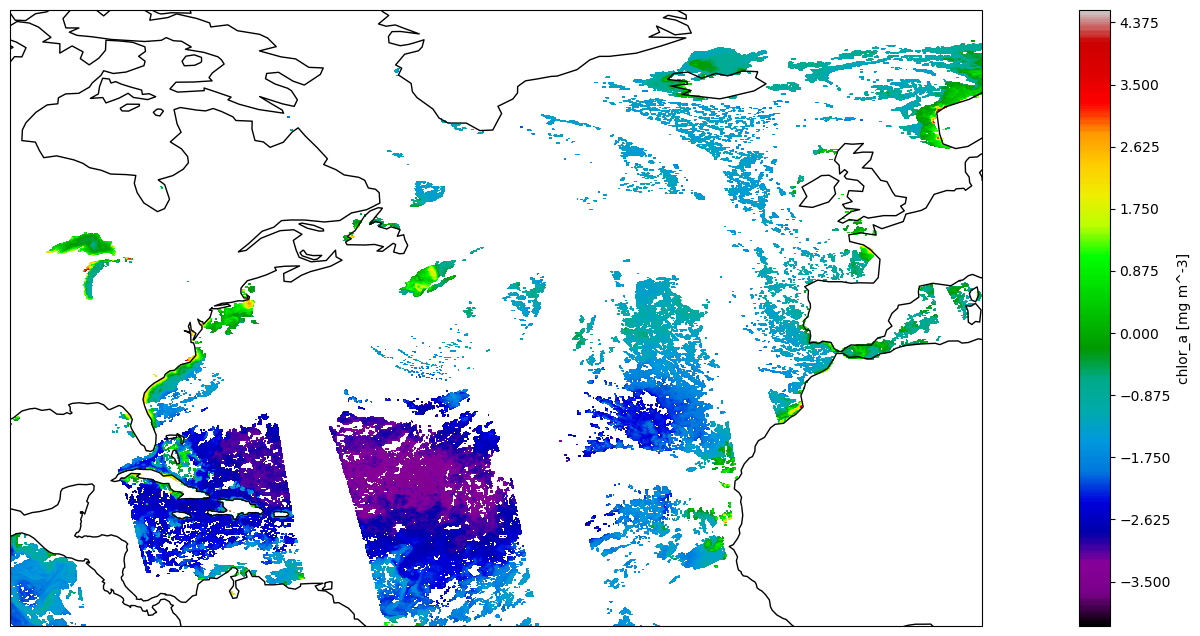

In [26]:
plt.figure(figsize=(25, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
plt.contourf(Lon, Lat, np.log(CHLOR_A), 400, cmap='nipy_spectral')
plt.colorbar().set_label(ds_full['chlor_a'].name + ' ['+ds_full['chlor_a'].units+']')
plt.show()

**Fig 3.** Visualizacion de la variable `Chlorophyll a` que se descargo de un servidor de OPeNDAP remoto, pero ahora la grafica se enfoca la region que cubren los datos descargados